In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss, BCELoss
import rasterio
import numpy as np
import matplotlib
import os
import glob
import shutil
import matplotlib.pyplot as plt
import cv2
from IPython.core.pylabtools import figsize
from Model.load_data import CustomGeoDataset
from Model.unet import unet

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("[INFO] training using {} ...".format(DEVICE))

[INFO] training using cpu ...


In [4]:
Image_Drive = "./Data6/image3"
Label_Drive = "./Data6/label3"

#augmented data
Image_aug = "./Data6/Transformed_images1"
Label_aug = "./Data6/Transformed_labels1"

image_path = glob.glob(os.path.join(Image_Drive, "*.tif"))
label_path = glob.glob(os.path.join(Label_Drive, "*.tif"))

image_size = len(image_path)
label_size = len(label_path)

print(image_size)
print(label_size)

405
405


In [5]:
aug_image_path = glob.glob(os.path.join(Image_aug, "*.tif"))
aug_label_path = glob.glob(os.path.join(Label_aug, "*.tif"))

image_path = image_path + aug_image_path
label_path = label_path + aug_label_path

image_size = len(image_path)
label_size = len(label_path)

print(image_size)
print(label_size)


3240
3240


In [6]:
# Instantiate the custom dataset with transformations
train_data = CustomGeoDataset(image_path, label_path)
print(len(train_data))

split_size = 0.8
train_size = int(split_size * len(train_data))
test_size = len(train_data) - train_size
train_data, test_data = torch.utils.data.random_split(train_data, [train_size, test_size])

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=32)

print(len(trainloader))
print(len(testloader))

3240
81
21


In [7]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y):
        # Ensure x has the correct shape
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension
        
        # Make prediction
        yhat = model(x)
        # Enter train mode
        model.train()
        # Compute loss
        loss = loss_fn(yhat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss
    return train_step

In [8]:
from Model.unet import unet

modelunet = unet(inchannels=7)
print(modelunet)
modelunet = modelunet.to(DEVICE)

unet(
  (conv_block1): Sequential(
    (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block11): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block22): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )

In [9]:
from torch.optim import Adam

# define training hyperparameters
INIT_LR = 1e-4
epochs = 100

# initialize our optimizer and loss function
optimizer = Adam(modelunet.parameters(), lr=INIT_LR)
lossfn = BCEWithLogitsLoss()

#train step
train_step = make_train_step(modelunet, optimizer, lossfn)
print(train_step)

<function make_train_step.<locals>.train_step at 0x000001BE513F2E60>


In [10]:
from tqdm import tqdm
from torchmetrics import JaccardIndex

def train(model, trainloader, optimizer, loss_fn, device):
    model.train()
    train_step = make_train_step(model, optimizer, loss_fn)
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    jaccard = JaccardIndex(task='binary').to(DEVICE)

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        x_batch, y_batch = data
        x_batch = x_batch.float().to(device)  # Ensure correct type
        y_batch = y_batch.float().to(device)

        # Forward pass and loss calculation
        loss = train_step(x_batch, y_batch)
        epoch_loss += loss.item()

        # Predictions untuk binary, untuk multi-class: loss function: CE, activation: softmax, classification: argmax, binary Loss fun: BCE, activation: sigmoid, classfication: threshold
        predictions = (model(x_batch) > 0.5).float()  # Binary thresholding at 0.5

        # Accuracy calculation
        correct_predictions += torch.sum(predictions == y_batch).item()
        total_predictions += (y_batch.size(0) * y_batch.size(1) * y_batch.size(2) * y_batch.size(3))

        # jaccard index (IoU) calculation
        jaccard.update(predictions, y_batch)

    accuracy = (correct_predictions/total_predictions) * 100  # Convert to percentage
    average_loss = epoch_loss / len(trainloader)
    iou = jaccard.compute()

    return average_loss, accuracy, iou

def evaluate(model, testloader, loss_fn, device):
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    jaccard = JaccardIndex(task='binary').to(DEVICE)

    with torch.no_grad():
        for x_batch, y_batch in testloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            # Forward pass and loss calculation
            yhat = model(x_batch)
            loss = loss_fn(yhat, y_batch)
            epoch_loss += loss.item()

            # Predictions
            predicted_classes = (yhat > 0.5).float() # Round to get binary predictions
            correct_predictions += torch.sum(predicted_classes == y_batch).item()
            total_predictions += (y_batch.size(0) * y_batch.size(1) * y_batch.size(2) * y_batch.size(3))

            #jaccard calculation
            jaccard.update(predicted_classes, y_batch)

    accuracy = (correct_predictions / total_predictions) * 100  # Convert to percentage
    average_loss = epoch_loss / len(testloader)
    iou = jaccard.compute()

    return average_loss, accuracy, iou


  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [01:48<00:00,  1.34s/it]


Epoch 1/100: Train Loss: 0.3678, Train Accuracy: 87.9532, Train IOU: 0.0000, Test Loss: 0.2966, Test Accuracy: 87.7766, Test IOU: 0.0000


100%|██████████| 81/81 [00:25<00:00,  3.23it/s]


Epoch 2/100: Train Loss: 0.2459, Train Accuracy: 89.1737, Train IOU: 0.1369, Test Loss: 0.2042, Test Accuracy: 92.0962, Test IOU: 0.4400


100%|██████████| 81/81 [00:25<00:00,  3.20it/s]


Epoch 3/100: Train Loss: 0.1969, Train Accuracy: 92.1334, Train IOU: 0.4110, Test Loss: 0.1715, Test Accuracy: 92.8459, Test IOU: 0.4702


100%|██████████| 81/81 [00:25<00:00,  3.21it/s]


Epoch 4/100: Train Loss: 0.1789, Train Accuracy: 92.8232, Train IOU: 0.4603, Test Loss: 0.1691, Test Accuracy: 93.2429, Test IOU: 0.5024


100%|██████████| 81/81 [00:25<00:00,  3.22it/s]


Epoch 5/100: Train Loss: 0.1702, Train Accuracy: 93.1503, Train IOU: 0.4817, Test Loss: 0.1553, Test Accuracy: 93.6555, Test IOU: 0.5243


100%|██████████| 81/81 [00:26<00:00,  3.00it/s]


Epoch 6/100: Train Loss: 0.1604, Train Accuracy: 93.5872, Train IOU: 0.5169, Test Loss: 0.1451, Test Accuracy: 94.0327, Test IOU: 0.5574


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 7/100: Train Loss: 0.1568, Train Accuracy: 93.7929, Train IOU: 0.5315, Test Loss: 0.1419, Test Accuracy: 94.3405, Test IOU: 0.5957


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 8/100: Train Loss: 0.1511, Train Accuracy: 93.9938, Train IOU: 0.5449, Test Loss: 0.1450, Test Accuracy: 93.7102, Test IOU: 0.5198


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 9/100: Train Loss: 0.1447, Train Accuracy: 94.2214, Train IOU: 0.5617, Test Loss: 0.1330, Test Accuracy: 94.2043, Test IOU: 0.5575


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 10/100: Train Loss: 0.1392, Train Accuracy: 94.4440, Train IOU: 0.5785, Test Loss: 0.1389, Test Accuracy: 94.6109, Test IOU: 0.6116


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 11/100: Train Loss: 0.1401, Train Accuracy: 94.4704, Train IOU: 0.5796, Test Loss: 0.1394, Test Accuracy: 94.7009, Test IOU: 0.6208


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 12/100: Train Loss: 0.1349, Train Accuracy: 94.6174, Train IOU: 0.5897, Test Loss: 0.1361, Test Accuracy: 94.6190, Test IOU: 0.6118


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 13/100: Train Loss: 0.1280, Train Accuracy: 94.9138, Train IOU: 0.6127, Test Loss: 0.1289, Test Accuracy: 94.5988, Test IOU: 0.5952


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 14/100: Train Loss: 0.1301, Train Accuracy: 94.8912, Train IOU: 0.6103, Test Loss: 0.1282, Test Accuracy: 94.4944, Test IOU: 0.5820


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 15/100: Train Loss: 0.1282, Train Accuracy: 94.9174, Train IOU: 0.6130, Test Loss: 0.1298, Test Accuracy: 94.4071, Test IOU: 0.5707


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 16/100: Train Loss: 0.1224, Train Accuracy: 95.1180, Train IOU: 0.6273, Test Loss: 0.1251, Test Accuracy: 94.8114, Test IOU: 0.6074


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 17/100: Train Loss: 0.1217, Train Accuracy: 95.1980, Train IOU: 0.6328, Test Loss: 0.1251, Test Accuracy: 95.0604, Test IOU: 0.6385


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 18/100: Train Loss: 0.1190, Train Accuracy: 95.2955, Train IOU: 0.6389, Test Loss: 0.1249, Test Accuracy: 94.9553, Test IOU: 0.6292


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 19/100: Train Loss: 0.1108, Train Accuracy: 95.6684, Train IOU: 0.6682, Test Loss: 0.1230, Test Accuracy: 94.8292, Test IOU: 0.6085


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 20/100: Train Loss: 0.1121, Train Accuracy: 95.6047, Train IOU: 0.6623, Test Loss: 0.1219, Test Accuracy: 95.0111, Test IOU: 0.6217


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 21/100: Train Loss: 0.1077, Train Accuracy: 95.8118, Train IOU: 0.6771, Test Loss: 0.1153, Test Accuracy: 95.2395, Test IOU: 0.6438


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 22/100: Train Loss: 0.1058, Train Accuracy: 95.8712, Train IOU: 0.6821, Test Loss: 0.1188, Test Accuracy: 95.2011, Test IOU: 0.6450


100%|██████████| 81/81 [00:35<00:00,  2.31it/s]


Epoch 23/100: Train Loss: 0.0998, Train Accuracy: 96.1495, Train IOU: 0.7021, Test Loss: 0.1195, Test Accuracy: 95.4961, Test IOU: 0.6695


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 24/100: Train Loss: 0.0997, Train Accuracy: 96.1975, Train IOU: 0.7060, Test Loss: 0.1151, Test Accuracy: 95.4049, Test IOU: 0.6521


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 25/100: Train Loss: 0.0942, Train Accuracy: 96.3640, Train IOU: 0.7176, Test Loss: 0.1121, Test Accuracy: 95.3408, Test IOU: 0.6412


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 26/100: Train Loss: 0.0990, Train Accuracy: 96.2571, Train IOU: 0.7092, Test Loss: 0.1198, Test Accuracy: 95.5390, Test IOU: 0.6833


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 27/100: Train Loss: 0.0970, Train Accuracy: 96.3231, Train IOU: 0.7141, Test Loss: 0.1130, Test Accuracy: 95.3009, Test IOU: 0.6433


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 28/100: Train Loss: 0.0926, Train Accuracy: 96.5134, Train IOU: 0.7290, Test Loss: 0.1166, Test Accuracy: 95.5729, Test IOU: 0.6808


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 29/100: Train Loss: 0.0855, Train Accuracy: 96.7037, Train IOU: 0.7423, Test Loss: 0.1073, Test Accuracy: 95.8248, Test IOU: 0.6848


100%|██████████| 81/81 [00:35<00:00,  2.31it/s]


Epoch 30/100: Train Loss: 0.0834, Train Accuracy: 96.8428, Train IOU: 0.7530, Test Loss: 0.1165, Test Accuracy: 95.4954, Test IOU: 0.6534


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 31/100: Train Loss: 0.0788, Train Accuracy: 97.0103, Train IOU: 0.7657, Test Loss: 0.1150, Test Accuracy: 95.3977, Test IOU: 0.6452


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 32/100: Train Loss: 0.0761, Train Accuracy: 97.1273, Train IOU: 0.7741, Test Loss: 0.1177, Test Accuracy: 95.8399, Test IOU: 0.6929


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 33/100: Train Loss: 0.0712, Train Accuracy: 97.2940, Train IOU: 0.7869, Test Loss: 0.1087, Test Accuracy: 95.8958, Test IOU: 0.6949


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 34/100: Train Loss: 0.0686, Train Accuracy: 97.3881, Train IOU: 0.7939, Test Loss: 0.1183, Test Accuracy: 95.8330, Test IOU: 0.7009


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 35/100: Train Loss: 0.0706, Train Accuracy: 97.3297, Train IOU: 0.7894, Test Loss: 0.1098, Test Accuracy: 96.0043, Test IOU: 0.6986


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 36/100: Train Loss: 0.0681, Train Accuracy: 97.4482, Train IOU: 0.7987, Test Loss: 0.1084, Test Accuracy: 95.9784, Test IOU: 0.6972


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 37/100: Train Loss: 0.0665, Train Accuracy: 97.4823, Train IOU: 0.8010, Test Loss: 0.1076, Test Accuracy: 96.2123, Test IOU: 0.7182


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 38/100: Train Loss: 0.0642, Train Accuracy: 97.5712, Train IOU: 0.8082, Test Loss: 0.1024, Test Accuracy: 96.2434, Test IOU: 0.7196


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 39/100: Train Loss: 0.0621, Train Accuracy: 97.6233, Train IOU: 0.8118, Test Loss: 0.1078, Test Accuracy: 96.1317, Test IOU: 0.7134


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 40/100: Train Loss: 0.0542, Train Accuracy: 97.8811, Train IOU: 0.8319, Test Loss: 0.1127, Test Accuracy: 96.1971, Test IOU: 0.7141


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 41/100: Train Loss: 0.0511, Train Accuracy: 97.9765, Train IOU: 0.8391, Test Loss: 0.1108, Test Accuracy: 96.2531, Test IOU: 0.7204


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 42/100: Train Loss: 0.0513, Train Accuracy: 97.9840, Train IOU: 0.8395, Test Loss: 0.1145, Test Accuracy: 96.1972, Test IOU: 0.7181


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 43/100: Train Loss: 0.0525, Train Accuracy: 97.9631, Train IOU: 0.8380, Test Loss: 0.1154, Test Accuracy: 96.1382, Test IOU: 0.7089


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 44/100: Train Loss: 0.0507, Train Accuracy: 98.0314, Train IOU: 0.8432, Test Loss: 0.1188, Test Accuracy: 95.8370, Test IOU: 0.6800


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 45/100: Train Loss: 0.0608, Train Accuracy: 97.7453, Train IOU: 0.8210, Test Loss: 0.1074, Test Accuracy: 96.1975, Test IOU: 0.7168


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 46/100: Train Loss: 0.0494, Train Accuracy: 98.0595, Train IOU: 0.8456, Test Loss: 0.1140, Test Accuracy: 96.3573, Test IOU: 0.7366


100%|██████████| 81/81 [00:35<00:00,  2.31it/s]


Epoch 47/100: Train Loss: 0.0456, Train Accuracy: 98.1859, Train IOU: 0.8552, Test Loss: 0.1212, Test Accuracy: 96.2059, Test IOU: 0.7112


100%|██████████| 81/81 [00:25<00:00,  3.22it/s]


Epoch 48/100: Train Loss: 0.0419, Train Accuracy: 98.2995, Train IOU: 0.8640, Test Loss: 0.1190, Test Accuracy: 96.3624, Test IOU: 0.7247


100%|██████████| 81/81 [00:25<00:00,  3.20it/s]


Epoch 49/100: Train Loss: 0.0402, Train Accuracy: 98.3636, Train IOU: 0.8690, Test Loss: 0.1157, Test Accuracy: 96.4832, Test IOU: 0.7376


100%|██████████| 81/81 [00:30<00:00,  2.70it/s]


Epoch 50/100: Train Loss: 0.0389, Train Accuracy: 98.4168, Train IOU: 0.8731, Test Loss: 0.1218, Test Accuracy: 96.4737, Test IOU: 0.7360


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 51/100: Train Loss: 0.0387, Train Accuracy: 98.4311, Train IOU: 0.8742, Test Loss: 0.1139, Test Accuracy: 96.4295, Test IOU: 0.7320


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 52/100: Train Loss: 0.0408, Train Accuracy: 98.3868, Train IOU: 0.8708, Test Loss: 0.1250, Test Accuracy: 96.2029, Test IOU: 0.7145


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 53/100: Train Loss: 0.0398, Train Accuracy: 98.4075, Train IOU: 0.8724, Test Loss: 0.1269, Test Accuracy: 96.3110, Test IOU: 0.7233


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 54/100: Train Loss: 0.0402, Train Accuracy: 98.4182, Train IOU: 0.8732, Test Loss: 0.1183, Test Accuracy: 96.1910, Test IOU: 0.7102


100%|██████████| 81/81 [00:29<00:00,  2.79it/s]


Epoch 55/100: Train Loss: 0.0370, Train Accuracy: 98.5072, Train IOU: 0.8803, Test Loss: 0.1239, Test Accuracy: 96.4664, Test IOU: 0.7336


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 56/100: Train Loss: 0.0337, Train Accuracy: 98.6009, Train IOU: 0.8875, Test Loss: 0.1239, Test Accuracy: 96.5999, Test IOU: 0.7471


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 57/100: Train Loss: 0.0357, Train Accuracy: 98.5627, Train IOU: 0.8845, Test Loss: 0.1235, Test Accuracy: 96.4506, Test IOU: 0.7380


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 58/100: Train Loss: 0.0439, Train Accuracy: 98.3434, Train IOU: 0.8672, Test Loss: 0.1332, Test Accuracy: 95.6358, Test IOU: 0.6743


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 59/100: Train Loss: 0.0485, Train Accuracy: 98.2202, Train IOU: 0.8578, Test Loss: 0.1179, Test Accuracy: 96.3080, Test IOU: 0.7205


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 60/100: Train Loss: 0.0353, Train Accuracy: 98.5613, Train IOU: 0.8845, Test Loss: 0.1268, Test Accuracy: 96.5759, Test IOU: 0.7412


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 61/100: Train Loss: 0.0320, Train Accuracy: 98.6814, Train IOU: 0.8938, Test Loss: 0.1286, Test Accuracy: 96.5066, Test IOU: 0.7377


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 62/100: Train Loss: 0.0330, Train Accuracy: 98.6642, Train IOU: 0.8925, Test Loss: 0.1334, Test Accuracy: 96.5848, Test IOU: 0.7427


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 63/100: Train Loss: 0.0280, Train Accuracy: 98.8153, Train IOU: 0.9044, Test Loss: 0.1367, Test Accuracy: 96.6270, Test IOU: 0.7456


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 64/100: Train Loss: 0.0272, Train Accuracy: 98.8586, Train IOU: 0.9078, Test Loss: 0.1389, Test Accuracy: 96.5802, Test IOU: 0.7428


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 65/100: Train Loss: 0.0270, Train Accuracy: 98.8658, Train IOU: 0.9083, Test Loss: 0.1395, Test Accuracy: 96.6223, Test IOU: 0.7447


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 66/100: Train Loss: 0.0263, Train Accuracy: 98.8963, Train IOU: 0.9107, Test Loss: 0.1471, Test Accuracy: 96.5752, Test IOU: 0.7398


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 67/100: Train Loss: 0.0462, Train Accuracy: 98.3770, Train IOU: 0.8696, Test Loss: 0.1437, Test Accuracy: 95.6521, Test IOU: 0.6741


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 68/100: Train Loss: 0.0363, Train Accuracy: 98.5934, Train IOU: 0.8870, Test Loss: 0.1239, Test Accuracy: 96.5250, Test IOU: 0.7362


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 69/100: Train Loss: 0.0295, Train Accuracy: 98.7923, Train IOU: 0.9025, Test Loss: 0.1375, Test Accuracy: 96.5171, Test IOU: 0.7343


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 70/100: Train Loss: 0.0394, Train Accuracy: 98.5366, Train IOU: 0.8824, Test Loss: 0.1338, Test Accuracy: 96.2031, Test IOU: 0.7127


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 71/100: Train Loss: 0.0304, Train Accuracy: 98.7805, Train IOU: 0.9017, Test Loss: 0.1411, Test Accuracy: 96.4057, Test IOU: 0.7229


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 72/100: Train Loss: 0.0267, Train Accuracy: 98.8866, Train IOU: 0.9100, Test Loss: 0.1381, Test Accuracy: 96.6485, Test IOU: 0.7485


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 73/100: Train Loss: 0.0237, Train Accuracy: 98.9926, Train IOU: 0.9184, Test Loss: 0.1488, Test Accuracy: 96.7391, Test IOU: 0.7575


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 74/100: Train Loss: 0.0238, Train Accuracy: 99.0018, Train IOU: 0.9191, Test Loss: 0.1435, Test Accuracy: 96.4656, Test IOU: 0.7376


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 75/100: Train Loss: 0.0273, Train Accuracy: 98.8984, Train IOU: 0.9109, Test Loss: 0.1469, Test Accuracy: 96.7357, Test IOU: 0.7559


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 76/100: Train Loss: 0.0227, Train Accuracy: 99.0441, Train IOU: 0.9225, Test Loss: 0.1529, Test Accuracy: 96.7225, Test IOU: 0.7557


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 77/100: Train Loss: 0.0212, Train Accuracy: 99.1004, Train IOU: 0.9270, Test Loss: 0.1539, Test Accuracy: 96.7529, Test IOU: 0.7573


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 78/100: Train Loss: 0.0207, Train Accuracy: 99.1261, Train IOU: 0.9290, Test Loss: 0.1526, Test Accuracy: 96.7381, Test IOU: 0.7552


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 79/100: Train Loss: 0.0201, Train Accuracy: 99.1477, Train IOU: 0.9307, Test Loss: 0.1559, Test Accuracy: 96.7031, Test IOU: 0.7506


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 80/100: Train Loss: 0.0209, Train Accuracy: 99.1301, Train IOU: 0.9293, Test Loss: 0.1577, Test Accuracy: 96.5268, Test IOU: 0.7433


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 81/100: Train Loss: 0.0229, Train Accuracy: 99.0529, Train IOU: 0.9231, Test Loss: 0.1650, Test Accuracy: 96.7192, Test IOU: 0.7536


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 82/100: Train Loss: 0.0198, Train Accuracy: 99.1668, Train IOU: 0.9322, Test Loss: 0.1630, Test Accuracy: 96.7742, Test IOU: 0.7589


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 83/100: Train Loss: 0.0190, Train Accuracy: 99.2036, Train IOU: 0.9352, Test Loss: 0.1671, Test Accuracy: 96.7002, Test IOU: 0.7497


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 84/100: Train Loss: 0.0194, Train Accuracy: 99.1972, Train IOU: 0.9347, Test Loss: 0.1660, Test Accuracy: 96.5922, Test IOU: 0.7444


100%|██████████| 81/81 [00:35<00:00,  2.30it/s]


Epoch 85/100: Train Loss: 0.0320, Train Accuracy: 98.8172, Train IOU: 0.9044, Test Loss: 0.1354, Test Accuracy: 96.4749, Test IOU: 0.7414


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 86/100: Train Loss: 0.0242, Train Accuracy: 99.0261, Train IOU: 0.9210, Test Loss: 0.1534, Test Accuracy: 96.6866, Test IOU: 0.7550


100%|██████████| 81/81 [00:35<00:00,  2.26it/s]


Epoch 87/100: Train Loss: 0.0300, Train Accuracy: 98.8954, Train IOU: 0.9106, Test Loss: 0.1298, Test Accuracy: 96.2166, Test IOU: 0.7194


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 88/100: Train Loss: 0.0303, Train Accuracy: 98.8643, Train IOU: 0.9082, Test Loss: 0.1387, Test Accuracy: 96.6050, Test IOU: 0.7499


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 89/100: Train Loss: 0.0218, Train Accuracy: 99.1069, Train IOU: 0.9275, Test Loss: 0.1529, Test Accuracy: 96.4650, Test IOU: 0.7405


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 90/100: Train Loss: 0.0229, Train Accuracy: 99.0735, Train IOU: 0.9248, Test Loss: 0.1583, Test Accuracy: 96.7116, Test IOU: 0.7513


100%|██████████| 81/81 [00:35<00:00,  2.29it/s]


Epoch 91/100: Train Loss: 0.0186, Train Accuracy: 99.2132, Train IOU: 0.9359, Test Loss: 0.1675, Test Accuracy: 96.7663, Test IOU: 0.7547


100%|██████████| 81/81 [00:35<00:00,  2.27it/s]


Epoch 92/100: Train Loss: 0.0211, Train Accuracy: 99.1493, Train IOU: 0.9308, Test Loss: 0.1556, Test Accuracy: 96.5958, Test IOU: 0.7413


100%|██████████| 81/81 [00:35<00:00,  2.28it/s]


Epoch 93/100: Train Loss: 0.0186, Train Accuracy: 99.2202, Train IOU: 0.9365, Test Loss: 0.1622, Test Accuracy: 96.7937, Test IOU: 0.7567


100%|██████████| 81/81 [00:35<00:00,  2.31it/s]


Epoch 94/100: Train Loss: 0.0168, Train Accuracy: 99.2879, Train IOU: 0.9419, Test Loss: 0.1697, Test Accuracy: 96.7974, Test IOU: 0.7581


100%|██████████| 81/81 [00:26<00:00,  3.07it/s]


Epoch 95/100: Train Loss: 0.0162, Train Accuracy: 99.3199, Train IOU: 0.9445, Test Loss: 0.1728, Test Accuracy: 96.8112, Test IOU: 0.7589


100%|██████████| 81/81 [00:25<00:00,  3.18it/s]


Epoch 96/100: Train Loss: 0.0165, Train Accuracy: 99.3097, Train IOU: 0.9437, Test Loss: 0.1741, Test Accuracy: 96.8265, Test IOU: 0.7618


100%|██████████| 81/81 [00:34<00:00,  2.32it/s]


Epoch 97/100: Train Loss: 0.0156, Train Accuracy: 99.3495, Train IOU: 0.9469, Test Loss: 0.1818, Test Accuracy: 96.8198, Test IOU: 0.7604


100%|██████████| 81/81 [00:36<00:00,  2.24it/s]


Epoch 98/100: Train Loss: 0.0151, Train Accuracy: 99.3676, Train IOU: 0.9483, Test Loss: 0.1763, Test Accuracy: 96.8474, Test IOU: 0.7639


100%|██████████| 81/81 [00:36<00:00,  2.24it/s]


Epoch 99/100: Train Loss: 0.0154, Train Accuracy: 99.3627, Train IOU: 0.9479, Test Loss: 0.1828, Test Accuracy: 96.8272, Test IOU: 0.7610


100%|██████████| 81/81 [00:36<00:00,  2.24it/s]


Epoch 100/100: Train Loss: 0.0163, Train Accuracy: 99.3310, Train IOU: 0.9454, Test Loss: 0.1765, Test Accuracy: 96.7315, Test IOU: 0.7568


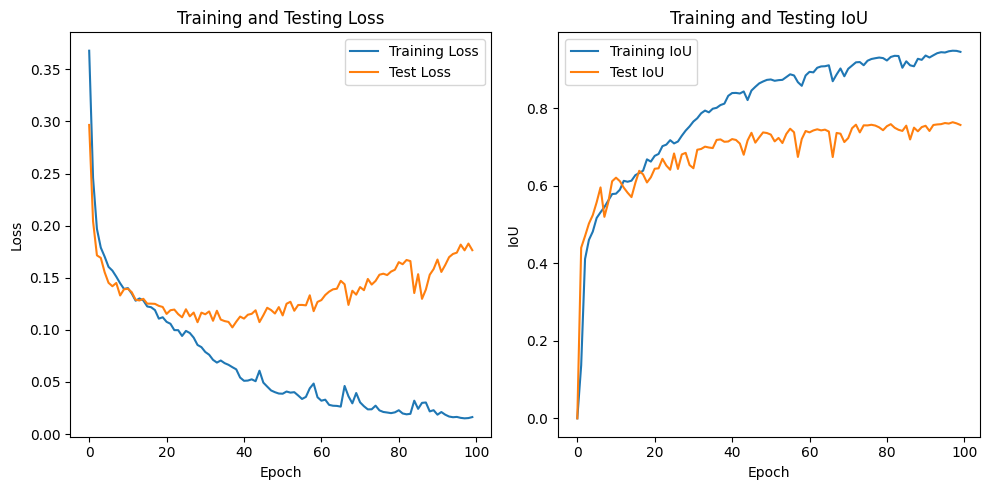

<All keys matched successfully>

In [11]:
best_loss = float('inf')
best_model_wts = None

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
train_ious = []
test_ious = []

early_stopping_tolerance = 3
early_stopping_threshold = 0.05

for epoch in range(epochs):
    train_loss, train_accuracy, train_iou = train(modelunet, trainloader, optimizer, lossfn, DEVICE)
    test_loss, test_accuracy, test_iou = evaluate(modelunet, testloader, lossfn, DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    train_ious.append(train_iou)
    test_ious.append(test_iou)

    print(f'Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train IOU: {train_iou:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test IOU: {test_iou:.4f}')

    # Save the best model
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_wts = modelunet.state_dict()

train_losses_cpu =  torch.tensor(train_losses, device='cpu')
test_losses_cpu =  torch.tensor(test_losses, device='cpu')
train_ious_cpu = torch.tensor(train_ious, device='cpu')
test_ious_cpu = torch.tensor(test_ious, device='cpu')

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_cpu, label='Training Loss')
plt.plot(test_losses_cpu, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_ious_cpu, label='Training IoU')
plt.plot(test_ious_cpu, label='Test IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Testing IoU')
plt.legend()

plt.tight_layout()
plt.show()

modelunet.load_state_dict(best_model_wts)



In [12]:
torch.save(modelunet, 'modelunet11.pth')
#load model
#modelunet = torch.load('modelunet.pth')


In [4]:
from Model.split_image import split

test_image = "./Citra Predict/processed_2005024.tif"
output_folder = "./Predict_20"

split(test_image, 128, 128, output_folder)

list_split_image = glob.glob(os.path.join(output_folder, "*.tif"))



(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 128, 128)
(7, 12